# Préparez des données pour un organisme de santé publique

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition, preprocessing
from functions import *
from scipy import stats
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', error_bad_lines=False, low_memory=False) # raw dataset

data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Exploration préliminaire

In [3]:
print(f'Le dataframe brut comporte {data.shape[0]} éléments et {data.shape[1]} colonnes.')

Le dataframe brut comporte 320772 éléments et 162 colonnes.


In [4]:
nutrition = ["energy_100g", "nutrition-score-fr_100g", "fat_100g", "saturated-fat_100g", "sugars_100g", "carbohydrates_100g",
             "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g", "trans-fat_100g", "cholesterol_100g",
             "vitamin-a_100g", "vitamin-c_100g", "calcium_100g", "iron_100g"]

maxvalue = {"energy_100g":3766,
            "fat_100g":100,
            "carbohydrates_100g":100,
            "fiber_100g":100,
            "proteins_100g":100,
            "sodium_100g":100,
            "saturated-fat_100g":100,
            "trans-fat_100g":100,
            "cholesterol_100g":100,
            "sugars_100g":100,
            "salt_100g":100,
            "vitamin-a_100g":100,
            "vitamin-c_100g":100,
            "calcium_100g":100,
            "iron_100g":100}


In [5]:
def plotunivar(list_of_vars, datatype):
    describes = [data[c].describe() for c in list_of_vars]
    sds = [[float(-x.loc["std"]), float(x.loc["std"])] for x in describes]
    stats_df = pd.DataFrame(data={'nutriment': list_of_vars, 'taux en g':[x.loc["mean"] for x in describes]})
    fig, ax = plt.subplots()
    grp = sns.barplot(ax=ax, x="nutriment", y="taux en g", data=stats_df, color=(0.25, 0.5, 0.9), order=list_of_vars)
    grp.set_title(f"Taux moyen et écart-type des {datatype} par portion de 100g")
    for item in grp.get_xticklabels():
        item.set_rotation(90)
        
    
    for p, s, d in zip(ax.patches, sds, describes):
        x = p.get_x()
        y = d.loc["mean"]
        w = p.get_width()
        h = p.get_height()
        min_y = s[0]
        max_y = s[1]
        plt.vlines(x+w/2, max(min_y+y, 0), max_y+y, color='k')
    
    plt.show()
    
def describe_data():
    plotunivar(nutrition[2:12], "nutriments")
    plotunivar(nutrition[12:], "vitamines")
    

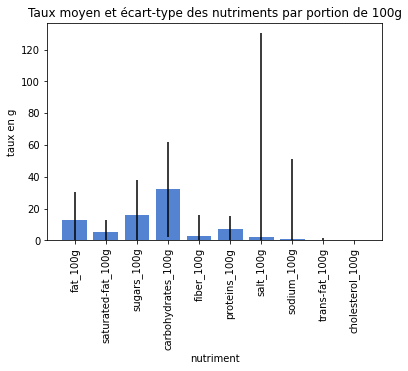

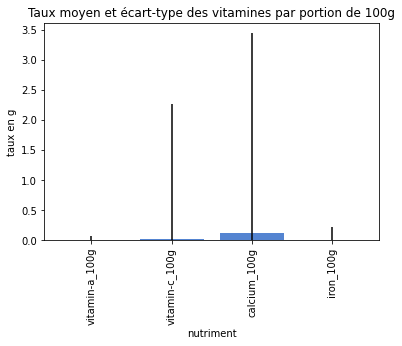

In [6]:
describe_data()


### Nettoyage des données

1) Exclusion des données inexploitables (nutriments non renseignés)

2) Remplacement des valeurs aberrantes des variables quantitatives (méthode de l'interquartille)

3) Exclusion des colonnes comportant trop de valeurs manquantes (-50% des données remplies)

In [7]:
# sampling rows containing not null nutrition data
for col in nutrition:
    data = data[data[col].notnull()]

# calculating default replacement value for each column
default_value = []
for col in maxvalue:
    data = data[data[col].notnull()]
    stts = data[col].describe()
    q1 = stts.loc["25%"]
    q3 = stts.loc["75%"]
    default_value.append(q3 + 1.5 * (q3 - q1))
    
# replacing aberrant values in parent dataframe
for index, row in data.iterrows():
    for col, default in zip(maxvalue, default_value):
        if row[col] > maxvalue[col]:
            data.at[index, col] = default
        elif row[col] < 0:
            data.at[index, col] = 0

# droping columns filled less than half
entries = data.shape[0]
for col in data.columns: 
    missing_values = data[col].isnull().sum()
    if missing_values > entries / 2 and col != 'categories':
        data = data.drop([col],axis=1)

### Bilan

Elements restants après traitement: 126397. Colonnes: 43. Doublons: 0



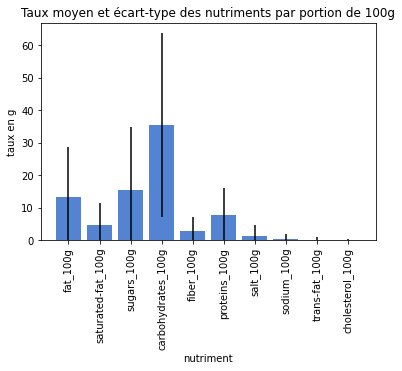

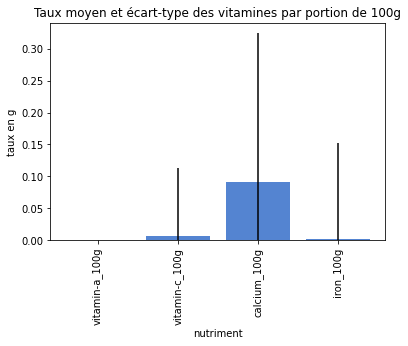

code 0
url 0
creator 0
created_t 0
created_datetime 0
last_modified_t 0
last_modified_datetime 0
product_name 110
brands 721
brands_tags 721
categories 125371
countries 0
countries_tags 0
countries_fr 0
ingredients_text 287
serving_size 4
additives_n 287
additives 292
additives_tags 42566
additives_fr 42566
ingredients_from_palm_oil_n 287
ingredients_that_may_be_from_palm_oil_n 287
nutrition_grade_fr 0
states 0
states_tags 0
states_fr 0
energy_100g 0
fat_100g 0
saturated-fat_100g 0
trans-fat_100g 0
cholesterol_100g 0
carbohydrates_100g 0
sugars_100g 0
fiber_100g 0
proteins_100g 0
salt_100g 0
sodium_100g 0
vitamin-a_100g 0
vitamin-c_100g 0
calcium_100g 0
iron_100g 0
nutrition-score-fr_100g 0
nutrition-score-uk_100g 0


In [8]:
print(f'Elements restants après traitement: {data.shape[0]}. Colonnes: {data.shape[1]}. Doublons: {data.shape[0]-len(data["code"].unique())}\n')
describe_data()
for col in data.columns:
    print(f"{col} {data[col].isnull().sum()}")


### ACP

Analyse en Composantes Principales sur les taux de nutriments par portion de 100g.

Objectifs:

  - Trouver des modes communs entre les variables


  - Découvrir les éventuelles variables redondantes.

In [9]:
def make_acp(list_of_cols):
    # choix du nombre de composantes à calculer
    n_comp = len(list_of_cols)
    print(f"Using {n_comp} composants")
    
    # selection des colonnes à prendre en compte dans l'ACP
    data_pca = data[list_of_cols]
    X = data_pca.values
    features = data_pca.columns
    
    # affichage de la matrice de corrélation
    d = pd.DataFrame(data=data, columns=list_of_cols)
    corr = d.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)

    # Eboulis des valeurs propres
    display_scree_plot(pca)

    # Cercle des corrélations
    pcs = pca.components_
    display_circles(pcs, n_comp, pca, [(0,1)],
                    labels = np.array(features))
    
    plt.show()


Using 11 composants


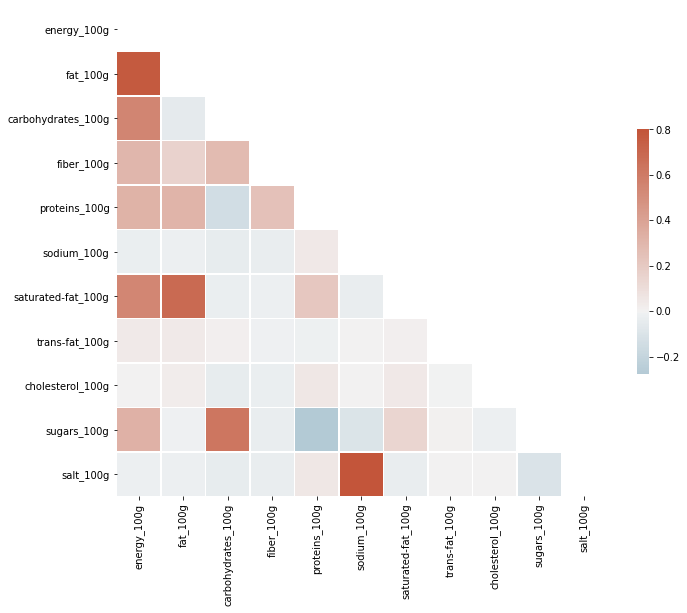

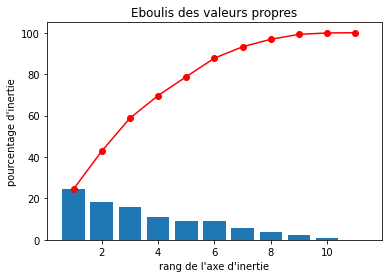

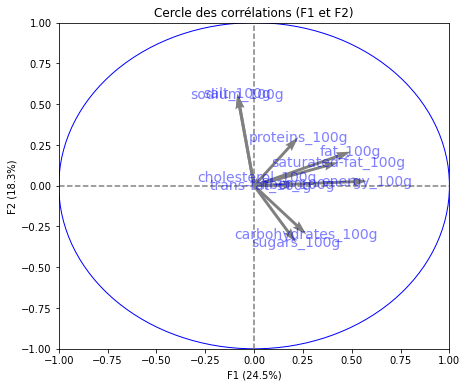

In [10]:
test_cols = ["energy_100g","fat_100g","carbohydrates_100g", "fiber_100g","proteins_100g","sodium_100g", "saturated-fat_100g",
             "trans-fat_100g", "cholesterol_100g", "sugars_100g", "salt_100g"]
make_acp(test_cols)

Using 16 composants


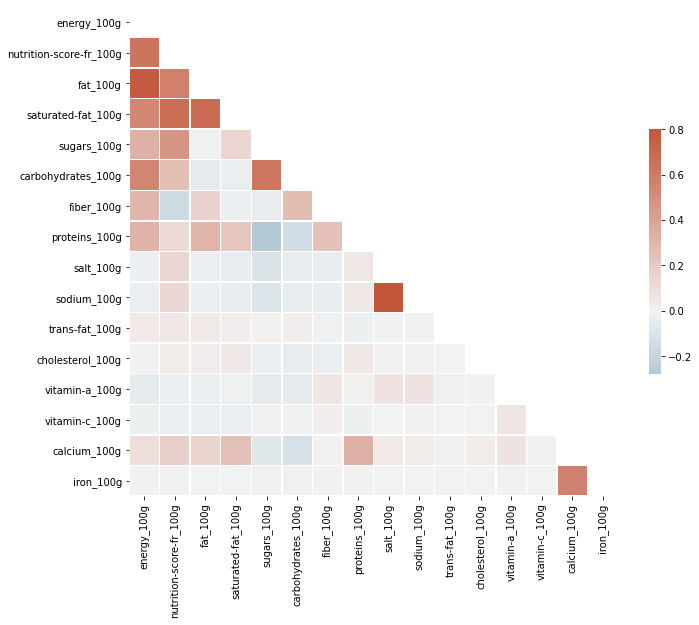

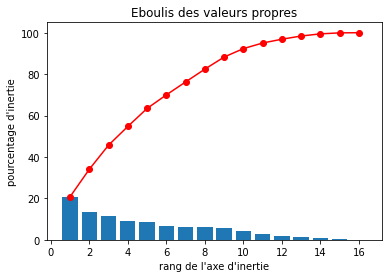

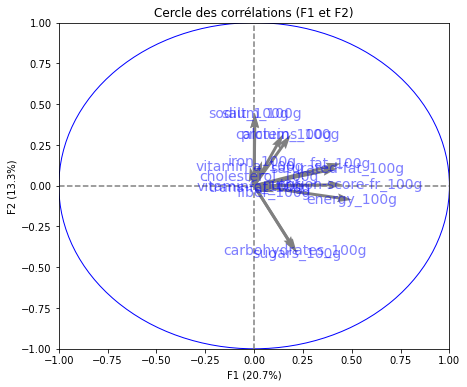

In [11]:
make_acp(nutrition)

Using 4 composants


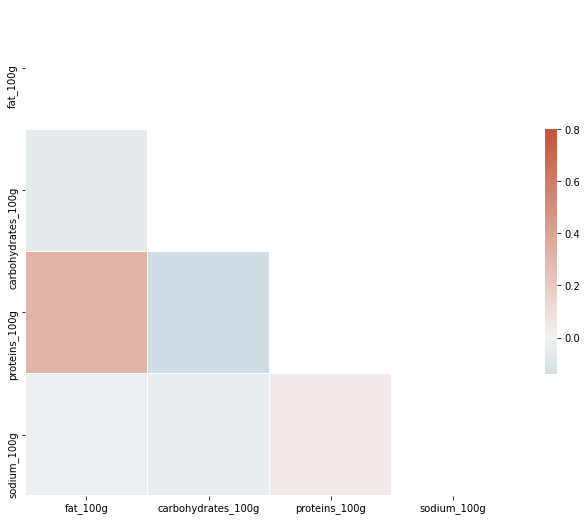

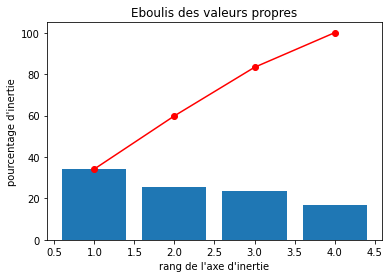

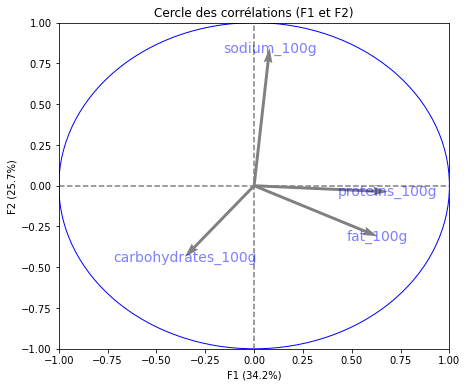

In [12]:
test_cols2 = ["fat_100g", "carbohydrates_100g",
             "proteins_100g", "sodium_100g",]
make_acp(test_cols2)

### ANOVA

Réalisation d'une analyse de variance entre les taux de nutriments par portion de 100g et le nutrigrade.

Après vérification de la normalité des données avec le test de Kolmogorov-Smirnov, on vérifie la contribution des nutriments au nutrigrade.

Hypothèse nulle h0: Il n'y a pas de variation du taux moyen du nutriment X entre les différents nutrigrades.

Hypothèse alternative: Il y a une variation du taux moyen du nutriment X entre les différents nutrigrades.

In [13]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT


def normalcheck(nutriment):
    ksr = str(stats.kstest(data[nutriment], 'norm'))
    ksr = ksr.split(", ")
    ksr[0] = round(float(ksr[0].split("=")[1]), 2)
    ksr[1] = float(ksr[1].split("=")[1][:-1])
    print(f"Test de normalité:\nKolmogorov-Smirnov = {ksr[0]}",
          f"(p value = {ksr[1]})")

    
def nutrianova(nutriment): 
    X = "nutrition_grade_fr" # qualitative
    Y = nutriment # quantitative
    sous_echantillon = data[data[X].notnull()]
    sous_echantillon = sous_echantillon[sous_echantillon[Y].notnull()]
    es = round(eta_squared(sous_echantillon[X],sous_echantillon[Y]), 2)
    print(f"\nRésultat de l'ANOVA:\neta²={es}")
    
    
def anova(nutriment):
    sns.displot(data[nutriment], kde=True)
    plt.show()
    normalcheck(nutriment)
    nutrianova(nutriment)
    
    
interact(lambda x:anova(x), x=nutrition)

interactive(children=(Dropdown(description='x', options=('energy_100g', 'nutrition-score-fr_100g', 'fat_100g',…

<function __main__.<lambda>(x)>

### Analyse qualitative des marques

Affichage d'un histogramme avec barres d'incertitudes représentant le score nutritionnel moyen et l'écart-type associé pour les aliments des marques les plus représentées dans le dataset.

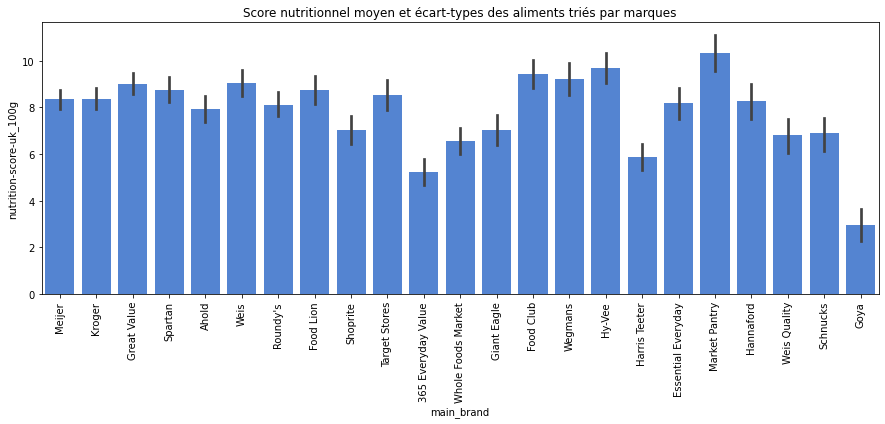

In [14]:
# creating a new column for main brand, using the fact that main brand is written first
def getfirstbrand(string):
    if isinstance(string, float):
        return string
    return string.split(',')[0]

data['main_brand'] = data['brands'].apply(getfirstbrand)

# selecting brands with more than 500 items in our dataframe
mybrands = []
for i, j in zip(data["main_brand"].value_counts().keys(), data["main_brand"].value_counts()):
    if j > 500:
        mybrands.append(i)

# plotting nutriscores
fig, ax = plt.subplots(figsize=(15, 5))
grp = sns.barplot(ax=ax, x="main_brand", y="nutrition-score-uk_100g", data=data, color=(0.25, 0.5, 0.9), order=mybrands)
grp.set_title("Score nutritionnel moyen et écart-types des aliments triés par marques")
for item in grp.get_xticklabels():
    item.set_rotation(90)